In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from pycocotools.coco import COCO
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
from utils import clean_sentence, get_prediction

In [2]:
# Define a transform to pre-process the testing images
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


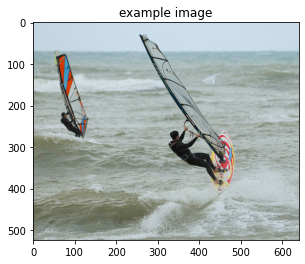

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


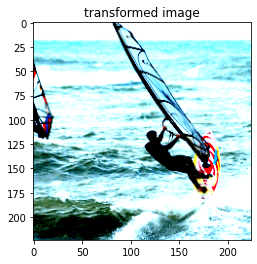

In [13]:
# Obtain sample image before and after pre-processing
orig_image, image = next(iter(data_loader))
# Convert image from torch.FloatTensor to numpy ndarray
transformed_image = image.numpy()
# Remove the first dimension which is batch_size euqal to 1
transformed_image = np.squeeze(transformed_image)
transformed_image = transformed_image.transpose((1, 2, 0))

# Visualize sample image, before pre-processing
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()
# Visualize sample image, after pre-processing
plt.imshow(transformed_image)
plt.title('transformed image')
plt.show()

In [4]:
# Load the most recent checkpoint
checkpoint = torch.load(os.path.join('./models', 'best-model.pkl'))

# Specify values for embed_size and hidden_size - we use the same values as in training step
embed_size = 256
hidden_size = 512

# Get the vocabulary and its size
vocab = data_loader.dataset.vocab
vocab_size = len(vocab)

# Initialize the encoder and decoder, and set each to inference mode
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the pre-trained weights
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# Move models to GPU if CUDA is available.
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [5]:
# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer th"

example output: [0, 3, 727, 21, 3, 321, 85, 3, 2825, 85, 321, 6, 3, 1317, 18, 1, 1, 1, 1, 1]


In [6]:
sentence = clean_sentence(output, vocab)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a bedroom with a bed , a dresser , bed and a desk .


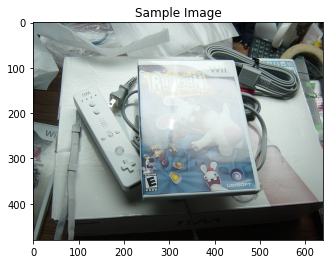

Caption without beam search:
a desk with a laptop and a keyboard
Top captions using beam search:
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .


In [7]:
get_prediction(data_loader, encoder, decoder, vocab)

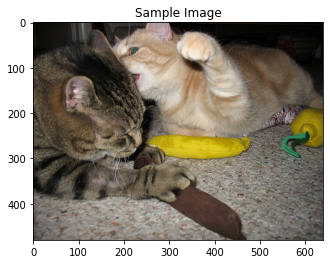

Caption without beam search:
a cat is laying on a bed with a book .
Top captions using beam search:
a cat that is laying down on a couch .
a cat that is laying down on a couch .
a cat that is laying down on a couch .


In [8]:
get_prediction(data_loader, encoder, decoder, vocab)